In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P \
    -O /tmp/sentiment.csv

--2022-10-19 12:46:31--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 2404:6800:4009:81e::200e, 142.250.183.46
Connecting to drive.google.com (drive.google.com)|2404:6800:4009:81e::200e|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ja71h2acrujnj5tom8o36q10kcjaggl2/1666163775000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=16cabd73-35af-4ed0-a723-42bb47eceea1 [following]
--2022-10-19 12:46:32--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ja71h2acrujnj5tom8o36q10kcjaggl2/1666163775000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=16cabd73-35af-4ed0-a723-42bb47eceea1
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 2404:6800:4009:830::2001, 142.250.76.161
Connecting to doc-0

In [3]:
import pandas as pd

dataset = pd.read_csv('/tmp/sentiment.csv')

sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

# Create a subwords dataset
### We can use the existing Amazon and Yelp reviews dataset with tensorflow_datasets's SubwordTextEncoder functionality. SubwordTextEncoder.build_from_corpus() will create a tokenizer for us. You could also use this functionality to get subwords from a much larger corpus of text as well, but we'll just use our existing dataset here.

### The Amazon and Yelp dataset we are using isn't super large, so we'll create a subword vocab_size of only the 1,000 most common words, as well as cutting off each subword to be at most 5 characters.

In [6]:
import tensorflow_datasets as tfds

vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=5)

In [8]:
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)

for i in encoded:
    print(tokenizer.decode([i]))

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]
I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


## Check that the tokenizer works appropriately

In [9]:
for i, sentence in enumerate(sentences):
    sentences[i] = tokenizer.encode(sentence)

In [11]:
print(sentences[1])

[625, 677, 626, 274, 380, 633, 148, 844, 789]


# Final pre-processing

In [12]:
import numpy as np

max_length = 50
trunc_type='post'
padding_type='post'

# Pad all sentences
sentences_padded = pad_sequences(sentences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences_padded[0:training_size]
testing_sentences = sentences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

## Train a Sentiment Model

In [13]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [14]:
num_epochs = 30
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_sentences, training_labels_final, epochs=num_epochs, 
                    validation_data=(testing_sentences, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 1s 4ms/step - loss: 0.6923 - accuracy: 0.5154 - val_loss: 0.6959 - val_accuracy: 0.4135
Epoch 2/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6889 - accuracy: 0.5355 - val_loss: 0.6957 - val_accuracy: 0.4411
Epoch 3/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6837 - accuracy: 0.5782 - val_loss: 0.6932 - val_accuracy: 0.4812
Epoch 4/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6741 - accuracy: 0.6183 - val_loss: 0.6860 - val_accuracy: 0.5088
Epoch 5/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6589 - accuracy: 0.6635 - val_loss: 0.6731 - val_accuracy: 0.5639
Epoch 6/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6374 - accuracy: 0.7150 - val_loss: 0.6582 - val_accuracy: 0.5990
Epoch 7/30
50/50 [==============================] - 0s 2ms/step - loss: 0.6078 - accuracy: 0.7633 - val_loss: 0.6325 - val_accuracy: 0.6742
Epoch 8/30
50/50 [==

## Visualize the Training Graph

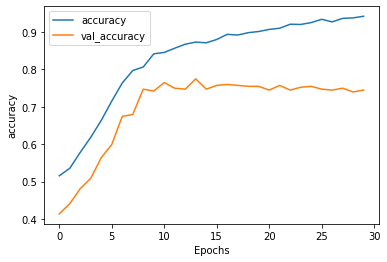

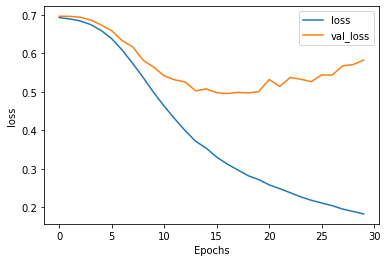

In [16]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Get files for visualizing the network

In [17]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(1000, 16)


In [18]:
import io

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(0, vocab_size - 1):
    word = tokenizer.decode([word_num])
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [19]:
# Download the files
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download('vecs.tsv')
    files.download('meta.tsv')

### yo can do prediction if you need